The files contain one message per line. Each line is composed by two columns: class (spam or ham) and raw message.

This data will be our labeled training set. Using these ham/spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

### Goal - To build a predictive model which will determine whether a text message is spam or ham. 

## DATA ANALYSIS

#### Imports required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from textblob import TextBlob
import pickle

[nltk_data] Downloading package stopwords to /home/omkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/omkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/omkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#reading the data
data = pd.read_csv("spam.csv", encoding = "latin-1")

# data = data[['v1', 'v2']]
# data = data.rename(columns = {'v1': 'label', 'v2': 'text'})

In [3]:
#checking first few rows
data.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
#removing unnecessary columns

data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)

In [5]:
#again check first few rows of data
display(data.head(n = 5))

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Lets look at the dataset info to see if everything is alright

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# check the statistics of data
data.groupby('class').describe()

message                                                               
        count unique                                                top freq
class                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

There are some repetative messages in the data. Lets check the top messages of data to find the most repetative messages

In [8]:
#check the top spam/ham messages

topMessages = data.groupby("message")["class"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


So. People are really busy it seems. "Sorry, i'll call later" tops the ham message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

Theres a quite lot of Ok..., Okie and Ok. in there too 

#### How long are the messages?

In [9]:
#add new column to the dataframe data to see the length of every message

data['length'] = data['message'].map(lambda text: len(text))
print (data.head())

  class                                            message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


<AxesSubplot:ylabel='Frequency'>

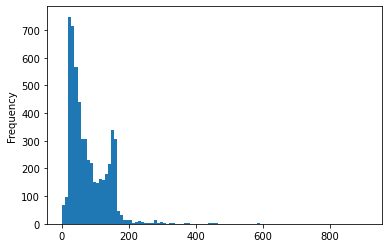

In [10]:
data.length.plot(bins=100, kind='hist')

We can see here maximum messages contains number of words in the range of [0, 200]. 

In [11]:
#check the statistics of the length of the message

data.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

The average length of the message is 80, while the minimum length is 2 and maximun length is 910.

#### Is there any difference in message length between spam and ham?

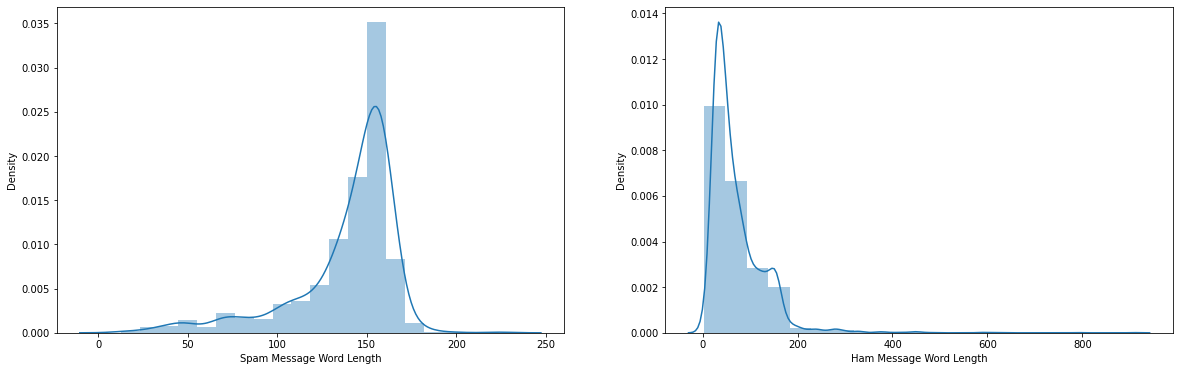

In [12]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(data[data["class"] == "spam"]["length"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(data[data["class"] == "ham"]["length"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

Looks like spam messages are usually longer. Maybe messageLength can become a feature to predict whether the message is spam/ ham ?

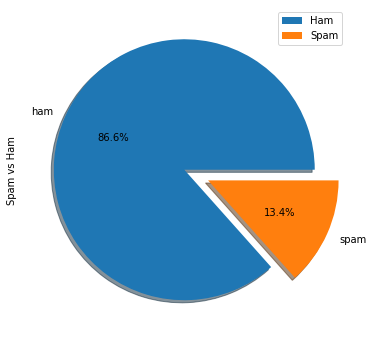

In [13]:
#Check what precentage of our data is spam/ham

data["class"].value_counts().plot(kind = 'pie', explode = [0,0.2], figsize = (6,6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

A lot of messages are actually not spam. About 87% of our dataset consists of normal messages.

While we split our data set into train and test or when we use cross validation, we will have to use stratified sampling, otherwise we have a chance of our training model being skewed towards normal messages. If the sample we choose to train our model consists majorly of normal messages, it may end up predicting everything as ham and we might not be able to figure this out since most of the messages we get are actually ham and will have a pretty good accuracy.

A very basic model would be a model that predicts everything as ham. It would have a decent accuracy. But then again, is that right? No. We will then have to use an accuracy metric that keeps this in mind. Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. Hence we will use fbeta score as our accuracy metric with inclination towards Precision

What is stratified sampling?

In statistics, stratified sampling is a method of sampling from a population which can be partitioned into subpopulations.Stratification is the process of dividing members of the population into homogeneous subgroups before sampling. The strata should define a partition of the population. 


Methods:

Proportionate allocation uses a sampling fraction in each of the strata that is proportional to that of the total population. For instance, if the population consists of X total individuals, m of which are male and f female (and where m + f = X), then the relative size of the two samples (x1 = m/X males, x2 = f/X females) should reflect this proportion

.
Optimum allocation (or disproportionate allocation) - The sampling fraction of each stratum is proportionate to both the proportion (as above) and the standard deviation of the distribution of the variable. Larger samples are taken in the strata with the greatest variability to generate the least possible overall sampling variance.

In [14]:
#Study individual Spam/ham words

spam_messages = data[data["class"] == "spam"]["message"]
ham_messages = data[data["class"] == "ham"]["message"]

spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

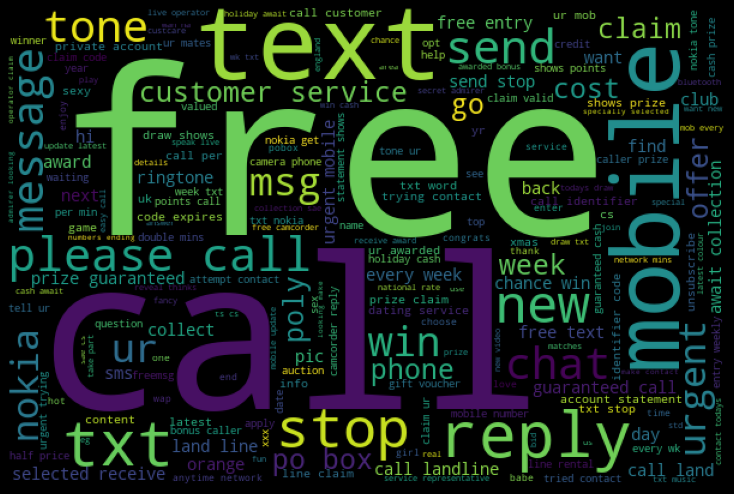

In [15]:
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

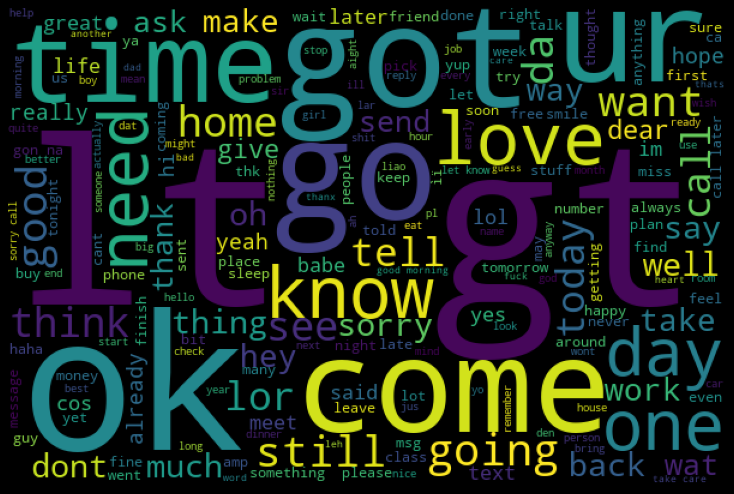

In [16]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [17]:
# Top 10 spam words

spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      219
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [18]:
# Top 10 Ham words

ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       989
gt      318
lt      316
get     301
ok      256
go      248
got     242
ur      237
know    236
like    231
dtype: int64

## Data Preprocessing

Cleaning textual data is a little different than regular data cleaning. There is a much heavier emphasis on text normalisation than removing outliers or leverage points. 

When used correctly, it reduces noise, groups terms with similar semantic meanings and reduces computational costs by giving us a smaller matrix to work with.

There are many types of Text Normalization.Like Case normalisation, Removing stop words, Removing punctuations and special symbols, Lemmatising/Stemming etc.

For this particular classification problem, we will use case normalisation and removing stop wordds.

In [19]:
def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
#     words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    message = message.lower()
    
    return message

data["message"] = data["message"].apply(cleanText)
data.head(n = 10)    

,class,message,length
0,ham,go until jurong point crazy available only in ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor u c already then say,49
4,ham,nah i dont think he goes to usf he lives aroun...,61
5,spam,freemsg hey there darling its been 3 weeks now...,148
6,ham,even my brother is not like to speak with me t...,77
7,ham,as per your request melle melle oru minnaminun...,160
8,spam,winner as a valued network customer you have b...,158
9,spam,had your mobile 11 months or more u r entitled...,154


#### Convert our clean text into a representation that a machine learning model can understand. We will use the Tfifd for this.

Now we will convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Here we will use the TF-IDF vectorizer (Term Frequency — Inverse Document Frequency), an embedding technique which takes into account the importance of each term to document.

TF-IDF vectorizes documents by calculating a TF-IDF statistic between the document and each term in the vocabulary. The document vector is constructed by using each statistic as an element in the vector.

The TF-IDF statistic for term i in document j is calculated as follows:

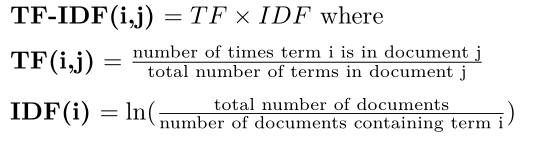

In [20]:
#specifing features and labels
labels = data['class']
text = data['message']

In [21]:
#splitting data into three sets - train, test and validation

X_train, X_remain, y_train, y_remain = train_test_split(text, labels, stratify = labels, random_state=0, test_size=0.3)

X_test, X_val, y_test, y_val = train_test_split(X_remain,y_remain,stratify = y_remain, random_state = 0, test_size = 0.5)

In [22]:
#check the shape of all three datasets

print("Training Data:",X_train.shape,y_train.shape )

print("Testing Data:", X_test.shape,y_test.shape)

print("Validation Data:", X_val.shape,y_val.shape )

Training Data: (3900,) (3900,)
Testing Data: (836,) (836,)
Validation Data: (836,) (836,)


In [23]:
X_train[:5]

3467    yay finally lol i missed our cinema trip last ...
1164    well im computerless time to make some oreo tr...
5059                       i think i am disturbing her da
1721    am watching house ûò very entertaining ûò am...
1921             no current and food here i am alone also
Name: message, dtype: object

In [24]:
#The CountVectorizer provides a simple way to 
#both tokenize a collection of text documents and build a vocabulary of known words, 
#but also to encode new documents using that vocabulary.

# create the transform
count_vec = CountVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return term-document matrix.
X_train_counts = count_vec.fit_transform(X_train)
# print(X_train_counts)

#Learn vocabulary and idf from training set.
tf_transformer = TfidfTransformer().fit(X_train_counts)

# Learn vocabulary and idf, return term-document matrix.
X_train_transformed = tf_transformer.transform(X_train_counts)

#test data
X_test_counts = count_vec.transform(X_test)
X_test_transformed = tf_transformer.transform(X_test_counts)

#converts classes into integer
labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

In [25]:
#label mapping of integer to class
label_mapping = dict(zip(labels.classes_,labels.transform(labels.classes_)))
print(label_mapping)

{'ham': 0, 'spam': 1}


# Model Building

A classification predictive modeling problem requires predicting or forecasting a label for a given observation.

An alternative to predicting the label directly, a model may predict the probability of an observation belonging to each possible class label.

This provides some flexibility both in the way predictions are interpreted and presented (choice of threshold and prediction uncertainty) and in the way the model is evaluated.

Although a model may be able to predict probabilities, the distribution and behavior of the probabilities may not match the expected distribution of observed probabilities in the training data.

This is especially common with complex nonlinear machine learning algorithms that do not directly make probabilistic predictions and instead use approximations.

The distribution of the probabilities can be adjusted to better match the expected distribution observed in the data. This adjustment is referred to as calibration, as in the calibration of the model or the calibration of the distribution of class probabilities.

Calibrate Classifier
A classifier can be calibrated in scikit-learn using the CalibratedClassifierCV class.

There are two ways to use this class: prefit and cross-validation.

You can fit a model on a training dataset and calibrate this prefit model using a hold out validation dataset.

Alternately, the CalibratedClassifierCV can fit multiple copies of the model using k-fold cross-validation and calibrate the probabilities predicted by these models using the hold out set. Predictions are made using each of the trained models.

In [26]:
model = MultinomialNB()

clf = model.fit(X_train_transformed,y_train_lables_trf)

# calibrated_svc = CalibratedClassifierCV(base_estimator= model,cv = 'prefit')

# calibrated_svc.fit(X_train_transformed,y_train_lables_trf)

predictions = model.predict(X_test_transformed)

#### Precision

Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. It is also called the Positive Predictive Value (PPV).


#### Recall

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate.


#### F1 Score

The F1 Score is the 2*((precision*recall)/(precision+recall)). It is also called the F Score or the F Measure. Put another way, the F1 score conveys the balance between the precision and the recall.

## Validation and Prediction

In [27]:
#Check accuracy on test data
print('Average accuracy on test set={}'.format(np.mean(predictions == labels.transform(y_test))))

Average accuracy on test set=0.9629186602870813


In [28]:
print ('Accuracy', accuracy_score(labels.transform(y_test), predictions))
print()
results = confusion_matrix(labels.transform(y_test), predictions)
print(results)
print()
print ('Report:')
print (classification_report(labels.transform(y_test), predictions)) 

Accuracy 0.9629186602870813

[[724   0]
 [ 31  81]]

Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.72      0.84       112

    accuracy                           0.96       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.96      0.96      0.96       836



In [29]:
from sklearn.metrics import fbeta_score

fbeta_score(labels.transform(y_test), predictions,beta=0.5)


0.9288990825688073

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).

## Deployment

In [32]:
weights = 'spam_detection_mnb.sav'
pickle.dump(clf,open(weights,'wb'))

vocab = 'vocabulary_mnb.sav'
pickle.dump(count_vec, open(vocab, 'wb'))

tfidf = 'tfidf_mnb.sav'
pickle.dump(tf_transformer,open(tfidf,'wb'))